![Elevvo Pathways](https://elevvo.tech/assets/nav_logo-5vkEKoZL.svg)
<h1>Customer Segmentation Using RFM Analysis</h1>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


First, we define the dtypes of our dataset. This is done so that the column InvoiceDate does not cause issues later. This will aid us in RFM analysis.

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [4]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

From the above dataset, we find that 135080 customers exist without an ID. Since it is an obligation in RFM analysis to possess an ID of some sort, these entries are useless to us. Therefore, we must drop all of them.

In [5]:
df.dropna(how='any', axis=0, subset=['CustomerID'], inplace=True)
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Now that we have cleaned the dataset. We can begin our RFM analysis.

In [7]:
# Define reference date for "Recency"
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID to calculate R, F, M
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'UnitPrice': 'sum'     # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()

We will group our dataset according to RFM (Recency, Frequency & Monetary). Since the data in this dataset is old (around 2010), we will use the most recent date in the dataset. In a real world dataset, we would usually use the current date.

In [8]:
# R Score: lower is better
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])

# F and M Score: higher is better
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5])

# Combine into a single RFM Score
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

Now, we will initially calculate the R, F & M score seperately. We use the <code>pd.qcut()</code> function to seperate our data into 5 quartiles (We do this to create a score from 1 to 5).
Finally, we combine all seperately calculated scores into a new column <code>rfm['RFM_Score']</code>.

Now comes the main part, Customer Segmentation!

We will use the scores we have calculated to add a new column that will tell us the status of each customer.

In [9]:
def segment(rfm):
    r = int(rfm['R_score'])
    f = int(rfm['F_score'])
    m = int(rfm['M_score'])
    
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 4 and f >= 3:
        return 'Loyal Customers'
    elif r >= 3 and m >= 4:
        return 'Big Spenders'
    elif r <= 2 and f <= 2 and m <= 2:
        return 'At Risk'
    elif r <= 2:
        return 'Hibernating'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment, axis=1)

In [10]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Segment
0,12346.0,326,2,2.08,1,2,1,121,At Risk
1,12347.0,2,7,481.21,5,4,5,545,Champions
2,12348.0,75,4,178.71,2,3,3,233,Hibernating
3,12349.0,19,1,605.10,4,1,5,415,Big Spenders
4,12350.0,310,1,65.30,1,1,2,112,At Risk


We can use this newly created dataset to filter out customers and identify customers at risk.

From the segmentation assigned to each customer, we can tailor our marketing for each customer
<ul>
    <li>Champions & Loyal Customers: Reward them with exclusive deals based on their shopping history</li>
    <li>At Risk & Hibernating: Attract their attention with discounted products & marketing campaigns</li>
    <li>Big Spenders: Recommend them higher end and pricier products based on their shopping history.</li>
</ul>

<h2>Visualizing RFM segments</h2>

<Axes: >

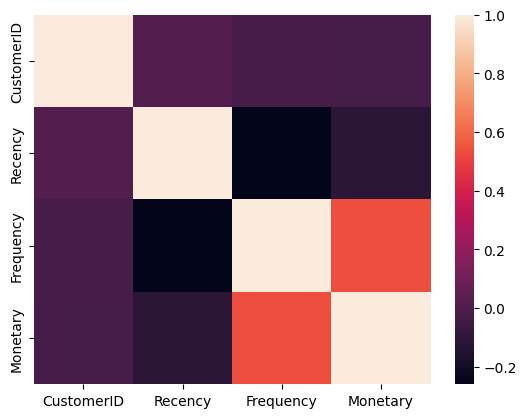

In [11]:
sns.heatmap(rfm.corr(numeric_only=True))

Text(0.5, 1.0, 'R Score (Lower is better)')

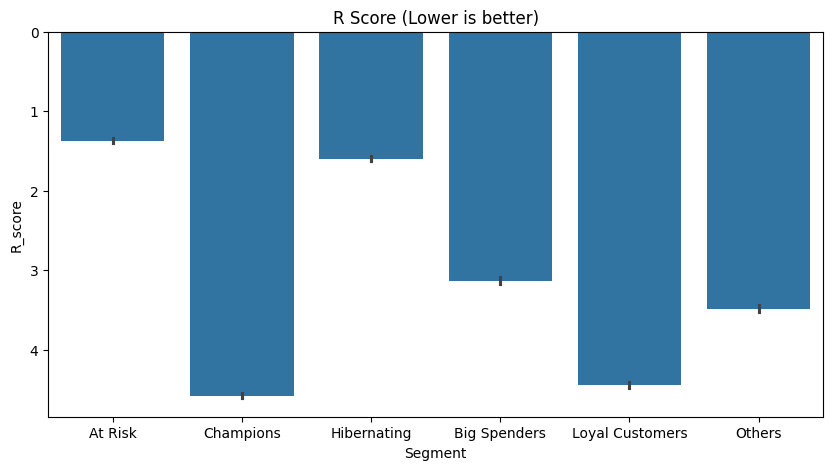

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(data=rfm, x='Segment', y='R_score')
plt.title('R Score')

Text(0.5, 1.0, 'F Score (Higher is better)')

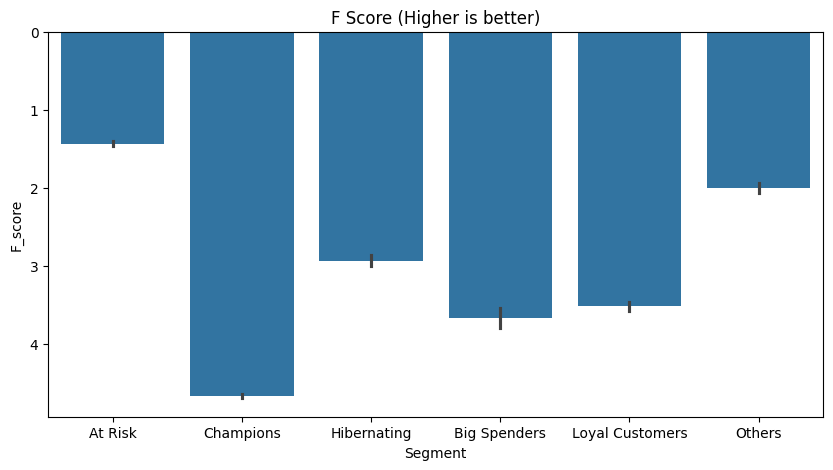

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(data=rfm, x='Segment', y='F_score')
plt.title('F Score')

Text(0.5, 1.0, 'M Score (Higher is better)')

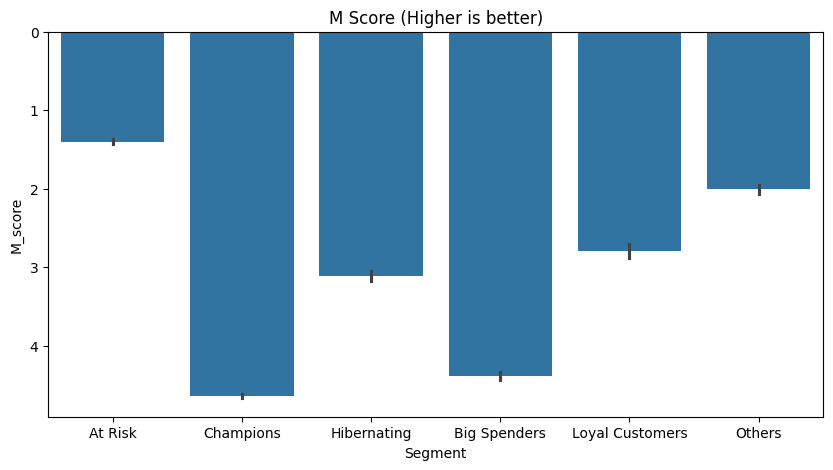

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(data=rfm, x='Segment', y='M_score')
plt.title('M Score')